# eCLIP-Seq differential binding analysis in Human 293T

In [1]:
library(dplyr)
library(reshape2)
library(ggplot2)
library(DESeq2)
library(pheatmap)
library(gridExtra)
library(ggnewscale)
library(tidyverse)
library(ggplotify)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching 

In [2]:
depth.mat <- read.table(file = 'data/depth.mat.csv',header = TRUE,sep = ',',row.names = 1) %>% as.matrix


In [3]:
coldata <- read.table(file = 'data/coldata.csv',header = TRUE,sep = ',',row.names = 1)


In [4]:
dds <- DESeqDataSetFromMatrix(
    countData = depth.mat,
    colData = coldata,
    design = ~Rep+Assay+Target
)

In [5]:
dds <- dds %>% 
estimateSizeFactors %>% estimateDispersions


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [6]:
depth.subcontrol <- (depth.mat[,coldata %>% arrange(Assay,Target,Antibody,Rep) %>% row.names][,9:16] - depth.mat[,coldata %>% arrange(Assay,Target,Antibody,Rep) %>% row.names][,1:8]) %>% 
(function(mymat) {
    mymat[mymat<0] <- 0
    mymat
})


In [7]:
dds.subcontrol <- depth.subcontrol %>% 
DESeqDataSetFromMatrix(
    colData = (coldata %>% arrange(Assay,Target,Antibody,Rep))[9:16,] %>% 
    mutate(Target=Target %>% factor(levels=c('WT','AR1KO'))),
    design = ~Rep+Antibody+Target
)


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



In [8]:
dds.input <- depth.mat[,coldata %>% arrange(Assay,Target,Antibody,Rep) %>% row.names][,1:8] %>% 
DESeqDataSetFromMatrix(
    colData = (coldata %>% arrange(Assay,Target,Antibody,Rep))[1:8,] %>% 
    mutate(Target=Target %>% factor(levels=c('WT','AR1KO'))),
    design = ~Rep+Antibody+Target
)


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function



In [9]:
dds.input_J2 <- dds.input[,dds.input@colData$Antibody=='J2']
dds.input_J2@design <- ~Rep+Target
dds.input_J2 <- dds.input_J2 %>% estimateSizeFactors %>% estimateDispersions


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [10]:
dds.subcontrol_J2.normalisedByInput <- dds.subcontrol[,dds.subcontrol@colData$Antibody=='J2']
dds.subcontrol_J2.normalisedByInput@colData$sizeFactor <- dds.input_J2@colData$sizeFactor
dds.subcontrol_J2.normalisedByInput@design <- ~Rep+Target
dds.subcontrol_J2.normalisedByInput <- dds.subcontrol_J2.normalisedByInput %>% estimateDispersions


gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



In [11]:
dds.subcontrol_J2.normalisedByInput.nbinomlrt <- dds.subcontrol_J2.normalisedByInput %>% 
nbinomLRT(full = ~Rep+Target,reduced = ~Rep)


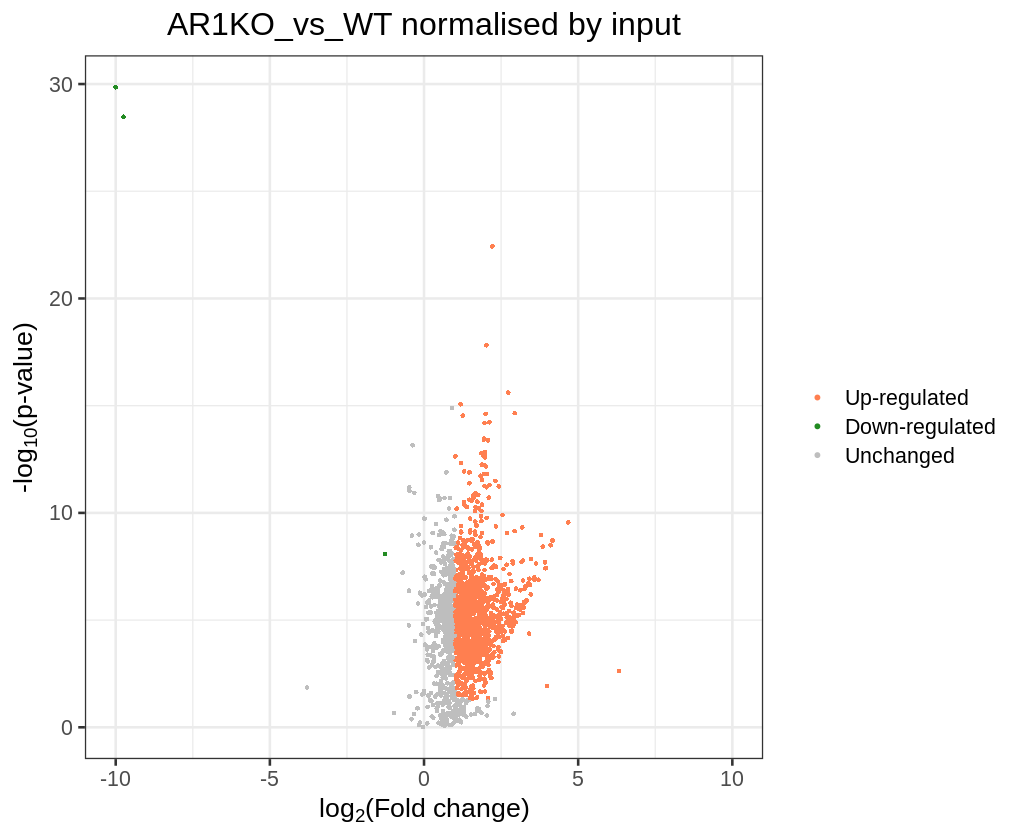

In [12]:
options(repr.plot.width=8.5,repr.plot.height=7)
g <- dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% results(name = 'Target_AR1KO_vs_WT') %>% data.frame %>% 
ggplot(
    mapping=aes(
        x = log2FoldChange,
        y = ifelse(-log10(pvalue) > 100,100,-log10(pvalue)),col=case_when(
            baseMean>=10 & log2FoldChange >= 1 & padj <= .05 ~ 'Up-regulated',
            baseMean>=10 & log2FoldChange <= -1 & padj <= .05 ~ 'Down-regulated',
            .default='Unchanged'
        ),shape=ifelse(-log10(pvalue) > 100,'trim','raw')
    )
) +
geom_point(size=1) +
scale_color_manual(
    name='',
    values = c('Up-regulated'='coral','Down-regulated'='forestgreen','Unchanged'='gray'),
    breaks=c('Up-regulated','Down-regulated','Unchanged')
) +
scale_shape_discrete(name='',guide='none') +
labs(title = 'AR1KO_vs_WT normalised by input',x=expression('log'[2]*'(Fold change)'),y=expression('-log'[10]*'(p-value)')) +
coord_cartesian(xlim=c(-10,10)) +
theme_bw(base_size = 16) +
guides(color=guide_legend(override.aes = c(size=1))) +
theme(plot.title = element_text(hjust=.5))

g


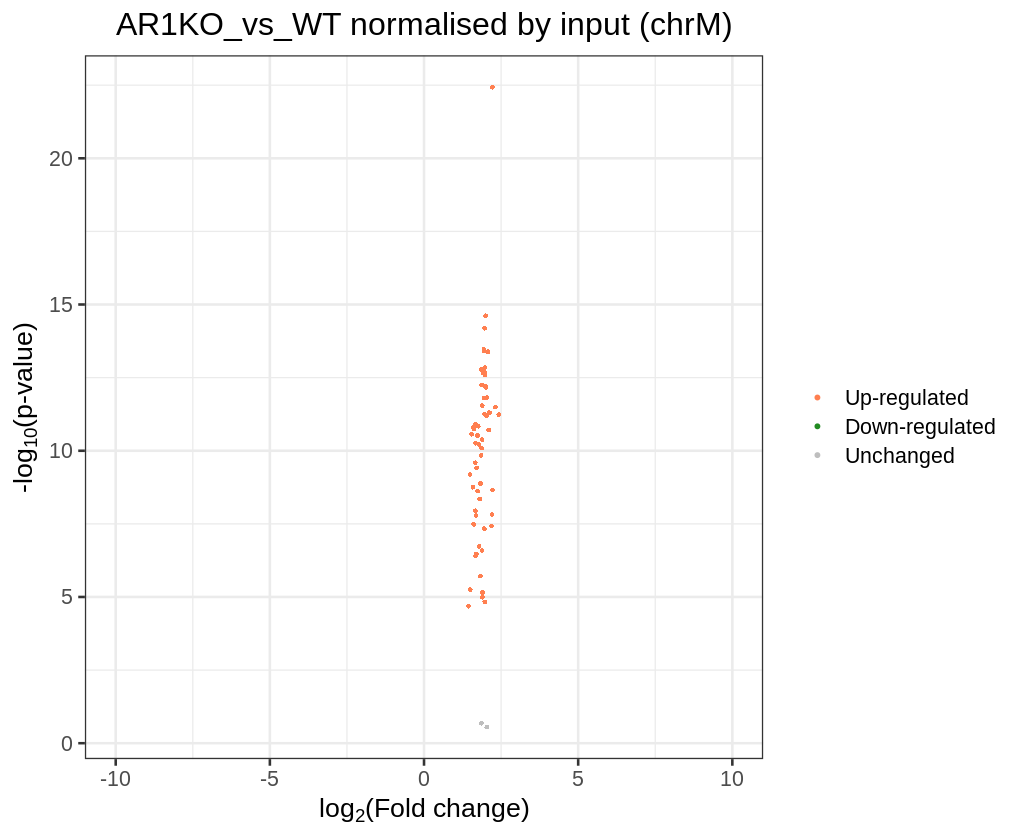

In [13]:
g <- dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% results(name = 'Target_AR1KO_vs_WT') %>% data.frame %>% 
mutate(peak=dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% row.names) %>% 
mutate(
    Chr=gsub('_.*','',peak),
    Start=gsub('chr[0-9a-zA-Z]*_|_[0-9]*$','',peak),
    End=gsub('.*_','',peak),
) %>% 
subset(baseMean >= 10) %>% 
subset(Chr == 'chrM') %>% 
ggplot(
    mapping=aes(
        x = log2FoldChange,y = ifelse(-log10(pvalue) > 100,100,-log10(pvalue)),
        col=case_when(
            baseMean >= 10 & log2FoldChange >= 1 & padj <= .05 ~ 'Up-regulated',
            baseMean >= 10 & log2FoldChange <= -1 & padj <= .05 ~ 'Down-regulated',
            .default='Unchanged'
        ) %>% factor(levels = c('Up-regulated','Down-regulated','Unchanged')),shape = ifelse(-log10(pvalue) > 100,'trim','raw')
    )
) +
geom_point(size=1) +
scale_color_manual(
    name='',
    values = c('Up-regulated'='coral','Down-regulated'='forestgreen','Unchanged'='gray'),
    breaks=c('Up-regulated','Down-regulated','Unchanged'),
    drop=FALSE
) +
scale_shape_discrete(name='',guide='none') +
labs(title = 'AR1KO_vs_WT normalised by input (chrM)',x=expression('log'[2]*'(Fold change)'),y=expression('-log'[10]*'(p-value)')) +
coord_cartesian(xlim=c(-10,10)) +
theme_bw(base_size = 16) +
guides(color=guide_legend(override.aes = c(size=1))) +
theme(plot.title = element_text(hjust=.5))

g


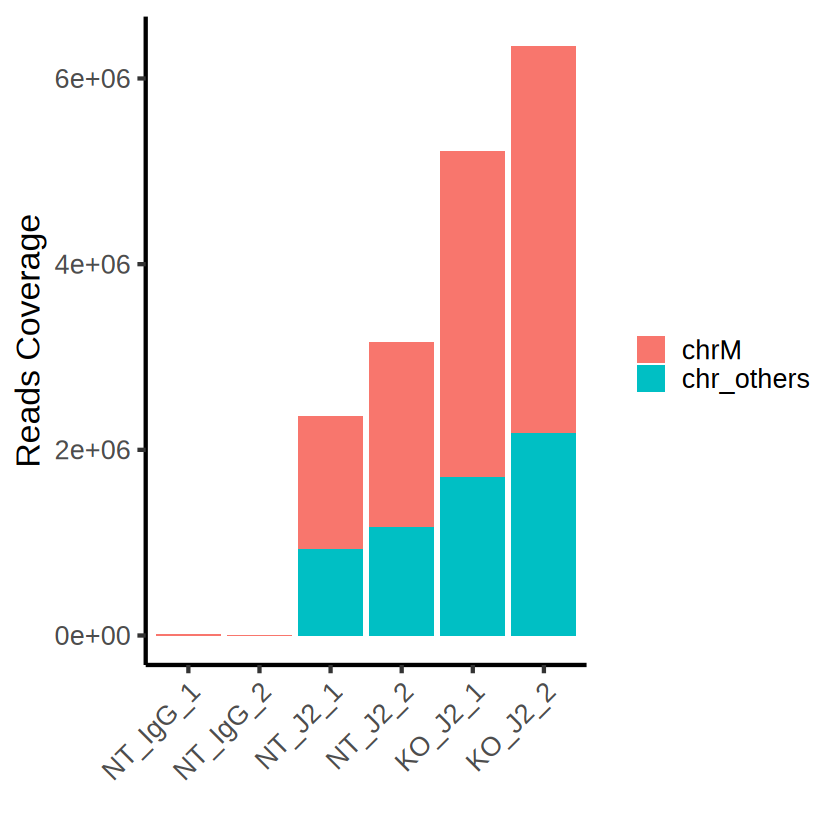

In [14]:
g <- dds.subcontrol %>% counts() %>% 
melt %>% 
mutate(chrM = ifelse(grepl('^chrM',Var1 %>% as.character),'chrM','chr_others') %>% factor(levels = c('chr_others','chrM'))) %>% 
filter((Var1 %>% as.character) %in% (dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% results(name = 'Target_AR1KO_vs_WT') %>% data.frame %>% 
filter(padj <= .05) %>% row.names)) %>% 

group_by(Var2,chrM) %>% 
reframe(cov.sum = value %>% sum) %>% 
group_by(Var2) %>% 
mutate(cov.sum.fraction = cov.sum/(cov.sum %>% sum)) %>% 
mutate(coldata[Var2 %>% as.character,],.after = 1) %>% 
mutate(
    Var2 = gsub('eCLIP_','',Var2) %>% factor(
    levels = c('WT_IgG_1','WT_IgG_2','WT_J2_1','WT_J2_2','AR1KO_J2_1','AR1KO_J2_2'),
    labels = c('NT_IgG_1','NT_IgG_2','NT_J2_1','NT_J2_2','KO_J2_1','KO_J2_2'))      
) %>% 

dplyr::rename(Sample = Var2) %>% na.omit %>% 

ggplot(mapping = aes(
    x = Sample,y = cov.sum,fill = chrM %>% factor(levels = c('chrM','chr_others'))
)) +
geom_bar(stat = 'identity') +
scale_fill_discrete(name = '') +

labs(x = '',y = 'Reads Coverage') +
theme_classic(base_size = 20) +
theme(
    axis.text.x = element_text(angle = 45,hjust = 1,vjust = 1)
)

g


In [15]:
differentialpeaks.AR1KO_vs_WT.Anno_stat.tsv <- read.table(file = 'results/differentialpeaks.AR1KO_vs_WT.Anno_stat.tsv',header = TRUE,sep = '\t')


In [16]:
differentialpeaks.AR1KO_vs_WT.Anno_stat <- differentialpeaks.AR1KO_vs_WT.Anno_stat.tsv %>% 
`colnames<-`(c(differentialpeaks.AR1KO_vs_WT.Anno_stat.tsv %>% dplyr::select(-'stat') %>% colnames,'null'))


In [17]:
differentialpeaks.AR1KO_vs_WT.Anno_stat <- differentialpeaks.AR1KO_vs_WT.Anno_stat %>% 
mutate(
    rmsk = differentialpeaks.AR1KO_vs_WT.Anno_stat %>% 
    with(Detailed.Annotation) %>% 
    sapply(function(x) grep('intron|CDS|UTR|intergenic|TTS|TSS|exon|codon',x %>% strsplit(split=';') %>% unlist,value = TRUE,invert = TRUE) %>% paste(collapse = ';')),
    .after='Detailed.Annotation'
)
    

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


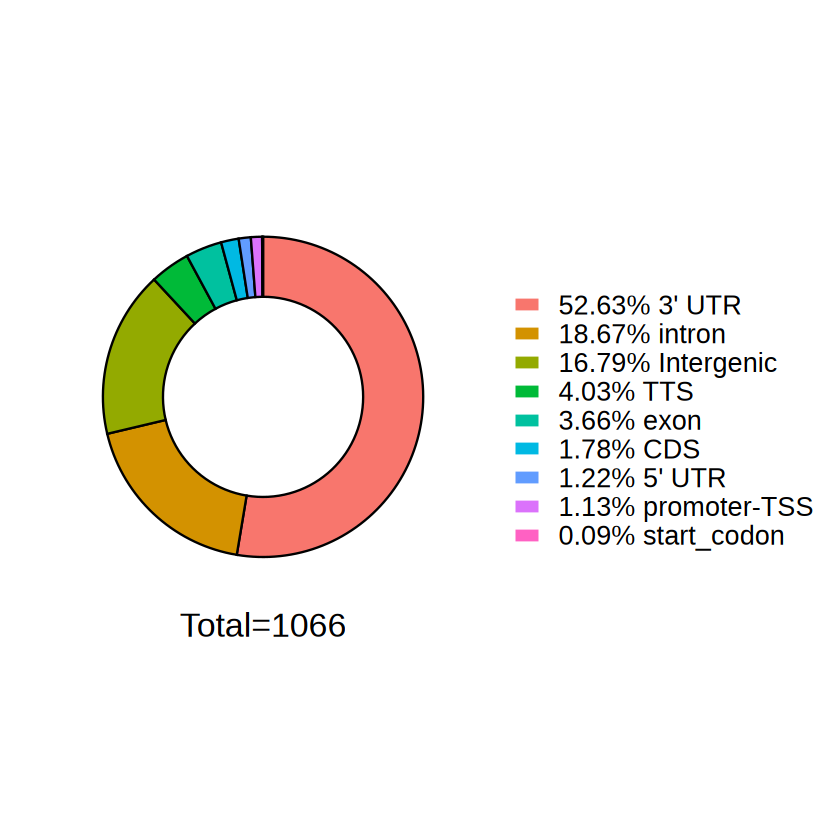

In [18]:
g <- dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% results(name = 'Target_AR1KO_vs_WT') %>% data.frame %>% 
rownames_to_column('name') %>% 
mutate(
    (differentialpeaks.AR1KO_vs_WT.Anno_stat %>% column_to_rownames('name') %>% dplyr::select(-c(4:11)))[name,]
) %>% 
filter(chrom != 'chrM' & (log2FoldChange %>% abs) >= 1 & padj < .01) %>% 
mutate(Func.refGene = case_when(
    grepl('intergenic',Annotation) ~ 'Intergenic',
    grepl('^SINE|^LTR|^Antisense|^LINE|^CpG|^Low_complexity|^Simple_repeat',Annotation) ~ 'Intergenic',
    .default = gsub(' .*','',Annotation)
)) %>% 
group_by(Func.refGene) %>% 
reframe(Func.refGene.count = Func.refGene %>% length) %>% 
arrange(-Func.refGene.count) %>% 
mutate(Func.refGene = gsub('UTR','\' UTR',Func.refGene)) %>% 
mutate(
    Func.refGene = Func.refGene %>% factor(
        levels = Func.refGene %>% as.character %>% unique
    )
) %>% 
mutate(ymax = Func.refGene.count %>% cumsum) %>% 
mutate(ymin = c(0,head(ymax,n = -1))) %>% 

(function(.) ggplot(.,mapping = aes(
    xmin = 2.5,xmax = 4,ymin = ymin,ymax = ymax,fill = Func.refGene
)) +
geom_rect(col = 'black') +
geom_line(mapping=aes(x=0,y=0,col = Func.refGene,group = Func.refGene),size = 2.5,alpha = 0) +
coord_polar(theta = "y", start=0) + xlim(c(0, 4)) +
scale_color_discrete(name = '',labels = with(.,paste0((100*Func.refGene.count/(Func.refGene.count %>% sum)) %>% round(digits = 2),'% ',Func.refGene))) +
scale_fill_discrete(guide='none',name = '',labels = with(.,paste0((100*Func.refGene.count/(Func.refGene.count %>% sum)) %>% round(digits = 2),'% ',Func.refGene))) +

labs(x = '',y = paste0('Total=',with(.,Func.refGene.count %>% sum))) +
theme_minimal(base_size = 20) +
theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank()
) +
guides(color = guide_legend(reverse = FALSE,override.aes = c(alpha = 1))))

g


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


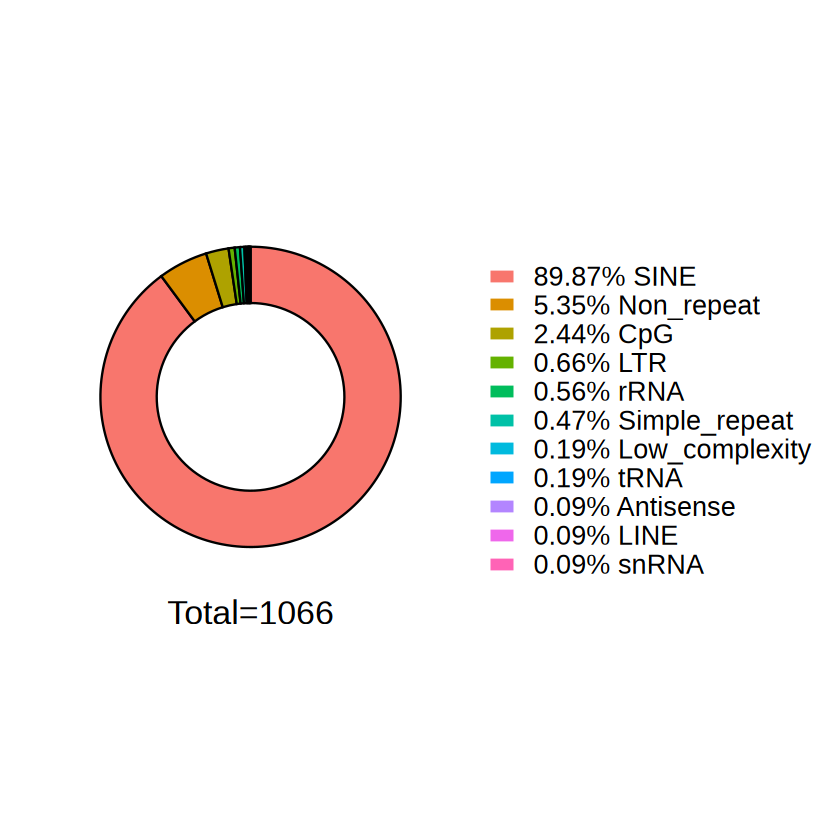

In [19]:
g <- dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% results(name = 'Target_AR1KO_vs_WT') %>% data.frame %>% 
rownames_to_column('name') %>% 
mutate(
    (differentialpeaks.AR1KO_vs_WT.Anno_stat %>% column_to_rownames('name') %>% dplyr::select(-c(4:11)))[name,]
) %>% 
filter(chrom != 'chrM' & (log2FoldChange %>% abs) >= 1 & padj < .01) %>% 
mutate(rmsk = case_when(
    rmsk == '' ~ 'Non_repeat',
    grepl('SINE',rmsk) ~ 'SINE',
    grepl('CpG',rmsk) ~ 'CpG',
    grepl('Simple_repeat',rmsk) ~ 'Simple_repeat',
    grepl('Antisense',rmsk) ~ 'Antisense',
    .default = gsub('\\|.*','',rmsk)
)) %>% 
group_by(rmsk) %>% 
reframe(rmsk.count = rmsk %>% length) %>% 
arrange(-rmsk.count) %>% 
mutate(rmsk = gsub('UTR','\' UTR',rmsk)) %>% 
mutate(
    rmsk = rmsk %>% factor(
        levels = rmsk %>% as.character %>% unique
    )
) %>% 
mutate(ymax = rmsk.count %>% cumsum) %>% 
mutate(ymin = c(0,head(ymax,n = -1))) %>% 

(function(.) ggplot(.,mapping = aes(
    xmin = 2.5,xmax = 4,ymin = ymin,ymax = ymax,fill = rmsk
)) +
geom_rect(col = 'black') +
geom_line(mapping=aes(x=0,y=0,col = rmsk,group = rmsk),size = 2.5,alpha = 0) +
coord_polar(theta = "y", start=0) + xlim(c(0, 4)) +
scale_color_discrete(name = '',labels = with(.,paste0((100*rmsk.count/(rmsk.count %>% sum)) %>% round(digits = 2),'% ',rmsk))) +
scale_fill_discrete(guide='none',name = '',labels = with(.,paste0((100*rmsk.count/(rmsk.count %>% sum)) %>% round(digits = 2),'% ',rmsk))) +

labs(x = '',y = paste0('Total=',with(.,rmsk.count %>% sum))) +
theme_minimal(base_size = 20) +
theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank()
) +
guides(color = guide_legend(reverse = FALSE,override.aes = c(alpha = 1))))

g


In [20]:
dds.prior <- DESeqDataSetFromMatrix(
    countData = 100 + dds@assays@data$counts,
    colData = dds@colData %>% data.frame,
    design = dds@design
)

dds.prior@colData$sizeFactor <- dds_input@colData$sizeFactor %>% rep(times = 2)


converting counts to integer mode

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



In [21]:
ddr.subcontrol_J2.normalisedByInput.nbinomlrt <- dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% results(name = 'Target_AR1KO_vs_WT') %>% data.frame %>% 
mutate(peak.id=dds.subcontrol_J2.normalisedByInput.nbinomlrt %>% row.names) %>% 
mutate(
    chrom=gsub('_.*','',peak.id) %>% factor(levels=paste0('chr',c(1:22,'X','M'))),
    start=peak.id %>% strsplit(split='_') %>% lapply(function(x) x[2]) %>% unlist %>% as.numeric,
    end=peak.id %>% strsplit(split='_') %>% lapply(function(x) x[3]) %>% unlist %>% as.numeric,
    strand=peak.id %>% strsplit(split='_') %>% lapply(function(x) x[4]) %>% unlist
)
                                                   

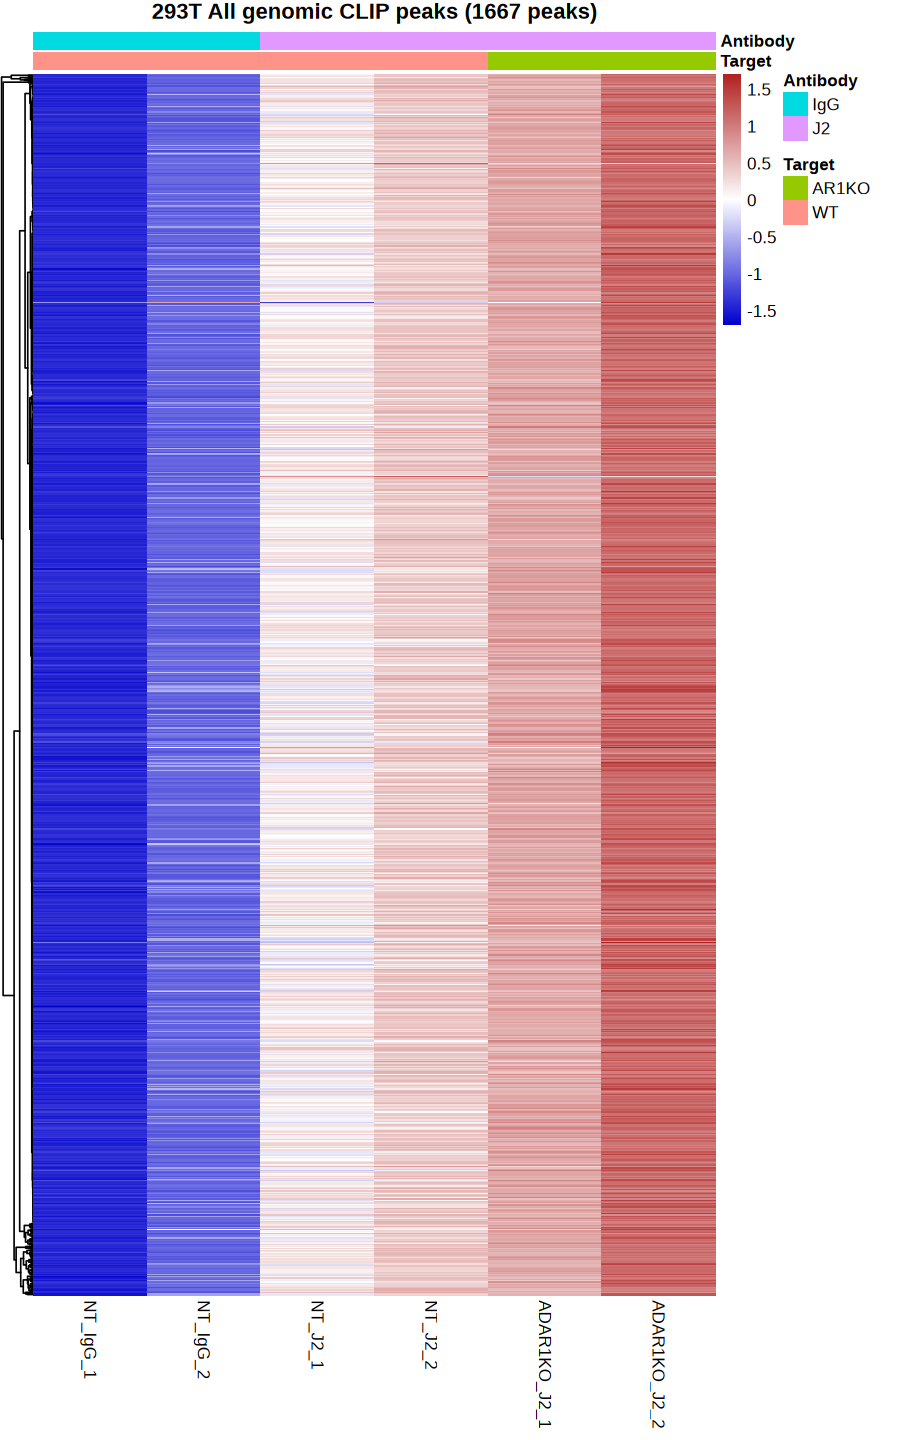

In [22]:
options(repr.plot.width = 7.5,repr.plot.height = 12)

#g <- (dds3 %>% counts(normalized = TRUE))[
g <- (dds.prior %>% counts(normalized = TRUE))[
    (dds.prior %>% row.names) %in% (
        ddr.subcontrol_J2.normalisedByInput.nbinomlrt %>% 
        filter(chrom != 'chrM') %>% with(peak.id)
    ),
    coldata %>% 
    mutate(
        Target = Target %>% factor(levels = c('WT','AR1KO','AR2KO')),
        Antibody = Antibody %>% factor(levels = c('IgG','J2'))
    ) %>% 
    arrange(Antibody,Target) %>% 
    filter(Assay == 'eCLIP' & Target != 'AR2KO') %>% 
    row.names
] %>% 
(function(.) log2(.)) %>% 
t %>% scale %>% t %>% 
pheatmap(
    main = paste0('293T All genomic CLIP peaks (',ddr.subcontrol_J2.normalisedByInput.nbinomlrt %>% 
        filter(chrom != 'chrM') %>% with(peak.id) %>% length,' peaks)'),
    treeheight_row = 15,
    labels_col = gsub('^AR','ADAR',gsub('WT_','NT_',gsub('eCLIP_','',coldata %>% 
    mutate(
        Target = Target %>% factor(levels = c('WT','AR1KO','AR2KO')),
        Antibody = Antibody %>% factor(levels = c('IgG','J2'))
    ) %>% 
    arrange(Antibody,Target) %>% 
    filter(Assay == 'eCLIP' & Target != 'AR2KO') %>% 
    row.names))),
    border = NA,
    annotation_col = dds.prior@colData %>% data.frame %>% dplyr::select(Antibody,Target),
    cluster_cols = FALSE,
    color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(255),
    show_rownames = FALSE,
    silent = TRUE
)

g
 

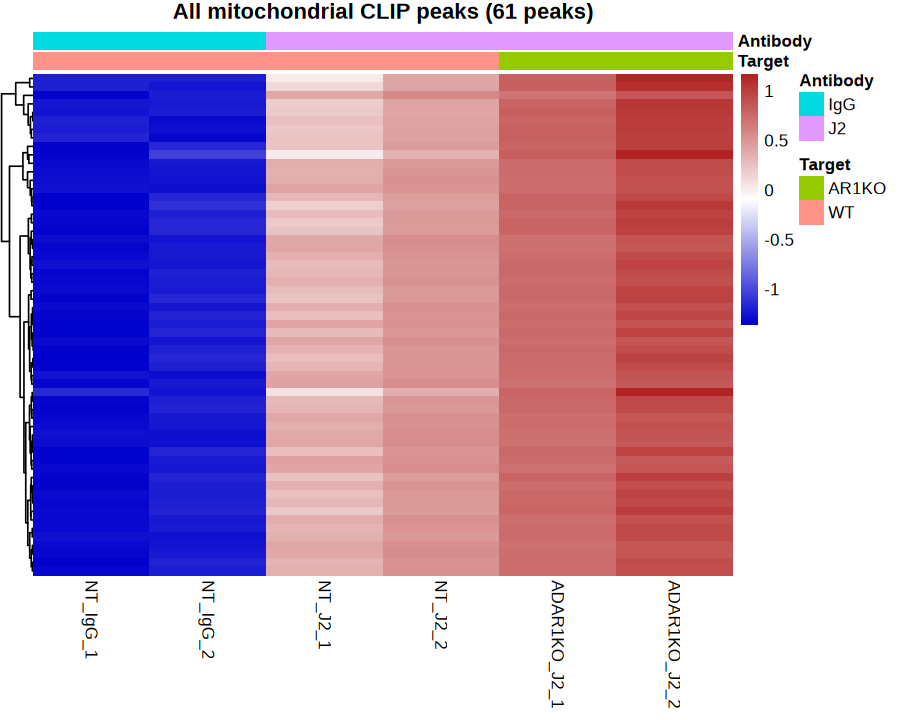

In [23]:
options(repr.plot.width = 7.5,repr.plot.height = 6)

g <- (dds.prior %>% counts(normalized = TRUE))[
    (dds.prior %>% row.names) %in% (
        ddr.subcontrol_J2.normalisedByInput.nbinomlrt %>% 
        filter(chrom == 'chrM') %>% with(peak.id)
    ),
    coldata %>% 
    mutate(
        Target = Target %>% factor(levels = c('WT','AR1KO','AR2KO')),
        Antibody = Antibody %>% factor(levels = c('IgG','J2'))
    ) %>% 
    arrange(Antibody,Target) %>% 
    filter(Assay == 'eCLIP' & Target != 'AR2KO') %>% 
    row.names
] %>% 
(function(.) log2(.)) %>% 
t %>% scale %>% t %>% 
pheatmap(
    main = paste0('All mitochondrial CLIP peaks (',ddr.subcontrol_J2.normalisedByInput.nbinomlrt %>% 
        filter(chrom == 'chrM') %>% with(peak.id) %>% length,' peaks)'),
    treeheight_row = 15,
    labels_col = gsub('^AR','ADAR',gsub('WT_','NT_',gsub('eCLIP_','',coldata %>% 
mutate(
    Target = Target %>% factor(levels = c('WT','AR1KO','AR2KO')),
    Antibody = Antibody %>% factor(levels = c('IgG','J2'))
) %>% 
arrange(Antibody,Target) %>% 
filter(Assay == 'eCLIP' & Target != 'AR2KO') %>% 
row.names))),
    border = NA,
    annotation_col = vsd2@colData %>% data.frame %>% dplyr::select(-c('Assay','Rep','sizeFactor')),
    cluster_cols = FALSE,
    color = colorRampPalette(colors = c('mediumblue','white','firebrick'))(255),
    show_rownames = FALSE,
    silent = TRUE
)

g
 

---

In [24]:
sessionInfo()


R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.1 LTS

Matrix products: default
BLAS/LAPACK: /home/vincentt/miniconda3/envs/R4.3-env/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Asia/Singapore
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggplotify_0.1.2             lubridate_1.9.3            
 [3] forcats_1.0.0               stringr_1.5.0              
 [5] purrr_1.0.2                 readr_2.1.4                
 [7] tidyr_1.3.0                 tibble_3.2.1               
 [9] tidyverse_2.0.